In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,roc_curve, accuracy_score, precision_score, recall_score, f1_score)
import joblib


RANDOM_STATE = 42
pd.set_option('display.max_columns', 200)

In [12]:
DATA_PATH = '/content/malicious_phish.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please upload your CSV to this path.")

df = pd.read_csv(DATA_PATH)
print('Data loaded. Shape:', df.shape)

Data loaded. Shape: (651191, 2)


In [13]:
# Step 1: head
print('\n--- df.head() ---')
print(df.head())



--- df.head() ---
                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement


In [14]:
print('\n--- df.info() ---')
print(df.info())


--- df.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None


In [15]:
print('\n--- df.describe() ---')
print(df.describe(include='all'))


--- df.describe() ---
                                                      url    type
count                                              651191  651191
unique                                             641119       4
top     http://style.org.hc360.com/css/detail/mysite/s...  benign
freq                                                  180  428103


In [16]:
print('\n--- Missing values per column ---')
print(df.isnull().sum())


--- Missing values per column ---
url     0
type    0
dtype: int64


In [17]:
print('\n--- nunique per column ---')
print(df.nunique())


--- nunique per column ---
url     641119
type         4
dtype: int64


In [23]:
data = df.copy()
# Manually set target_col to 'type' as it contains the classification labels.
target_col = 'type'

print('Inferred target column:', target_col)


# Separate features and target
X = data.drop(columns=[target_col])
y = data[target_col]


# Show class balance
print('\nTarget class distribution:')
print(y.value_counts(dropna=False))


# Automatic column type detection
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print('\nNumeric columns:', num_cols)
print('Categorical columns:', cat_cols)


# For columns that look numeric but are object, try to coerce
for c in X.columns:
    if c not in num_cols and c not in cat_cols:
        # mixed types; attempt conversion
        try:
            X[c] = pd.to_numeric(X[c])
            num_cols.append(c)
        except Exception:
            cat_cols.append(c)


# Build preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

Inferred target column: type

Target class distribution:
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

Numeric columns: []
Categorical columns: ['url']


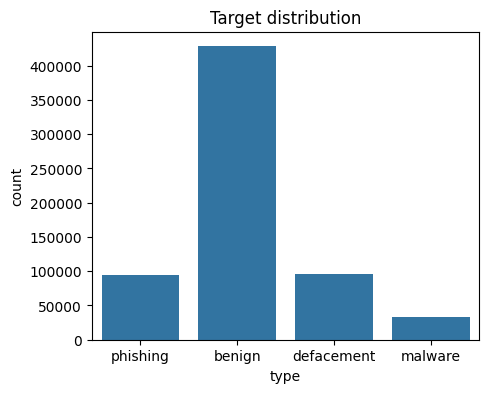

In [25]:
# 4. Exploratory Data Analysis (minimum 3 plots)
# Plot 1: target distribution
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title('Target distribution')
plt.show()


# Plot 2: numeric feature distributions (first 4)
if num_cols:
    fig, axes = plt.subplots(min(4, len(num_cols)), 1, figsize=(8, 3*min(4, len(num_cols))))
    for i, col in enumerate(num_cols[:4]):
        ax = axes[i] if len(num_cols[:4])>1 else axes
        sns.histplot(X[col].dropna(), kde=True, ax=ax)
        ax.set_title(f'Distribution: {col}')
    plt.tight_layout()
    plt.show()


# Plot 3: correlation heatmap for numeric features
if len(num_cols) >= 2:
    plt.figure(figsize=(8,6))
    corr = X[num_cols].corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation heatmap (numeric features)')
    plt.show()


# Additional: boxplot for outlier inspection for first numeric column
if num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=X[num_cols[0]])
    plt.title(f'Boxplot: {num_cols[0]}')
    plt.show()

In [37]:
print('Final feature shape:', X.shape)

Final feature shape: (651191, 16)


In [38]:
# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (520952, 16) Test shape: (130239, 16)


In [39]:
clf_lr = Pipeline(steps=[('preprocessor', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
clf_rf = Pipeline(steps=[('preprocessor', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))])


print('\nTraining Logistic Regression...')
clf_lr.fit(X_train, y_train)
print('Done.')


print('\nTraining Random Forest...')
clf_rf.fit(X_train, y_train)
print('Done.')


Training Logistic Regression...
Done.

Training Random Forest...
Done.


In [40]:
models = {'LogisticRegression': clf_lr, 'RandomForest': clf_rf}
results = {}
for name, model in models.items():
    print(f"\nEvaluating model: {name}")
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    # if predict_proba available
    y_proba_test = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    y_proba_train = model.predict_proba(X_train)[:,1] if hasattr(model, 'predict_proba') else None

    results[name] = {
        'y_pred_test': y_pred_test,
        'y_pred_train': y_pred_train,
        'y_proba_test': y_proba_test,
        'y_proba_train': y_proba_train
    }

    # Print basic accuracies
    print('Train accuracy:', accuracy_score(y_train, y_pred_train))
    print('Test accuracy:', accuracy_score(y_test, y_pred_test))


Evaluating model: LogisticRegression
Train accuracy: 0.8691702882415271
Test accuracy: 0.8697548353411805

Evaluating model: RandomForest
Train accuracy: 0.9733142400835394
Test accuracy: 0.9596127120140664


In [41]:
best = 'RandomForest'
model = models[best]

sample_idx = X_test.index[:5]
sample_X = X_test.loc[sample_idx]
raw_samples = df.loc[sample_idx]


print('\nSample raw rows:')
print(raw_samples.head(5))


sample_preds = model.predict(sample_X)
print('\nSample predictions:', sample_preds)


if hasattr(model, 'predict_proba'):
    sample_proba = model.predict_proba(sample_X)[:,1]
    print('\nSample probabilities:', sample_proba)


Sample raw rows:
                                                      url    type
47517       metrodemontreal.com/green/cadillac/index.html  benign
29515   msn.foxsports.com/mlb/story/121409-Latest-MLB-...  benign
133216                                connectedgoods.com/  benign
380059                     avantasia.interactivearea.com/  benign
481883                    tvrage.com/Back_at_the_Barnyard  benign

Sample predictions: ['benign' 'benign' 'benign' 'benign' 'benign']

Sample probabilities: [0. 0. 0. 0. 0.]



--- Evaluating LogisticRegression ---

Training Metrics for LogisticRegression:
Accuracy: 0.8691702882415271
Precision: 0.8598346423771387
Recall: 0.8691702882415271
F1-score: 0.8553950687720454

Testing Metrics for LogisticRegression:
Accuracy: 0.8697548353411805
Precision: 0.8605851757793129
Recall: 0.8697548353411805
F1-score: 0.8560004882316768
ROC AUC: Not directly applicable for multiclass with current setup

Confusion Matrix for LogisticRegression (Test Set):


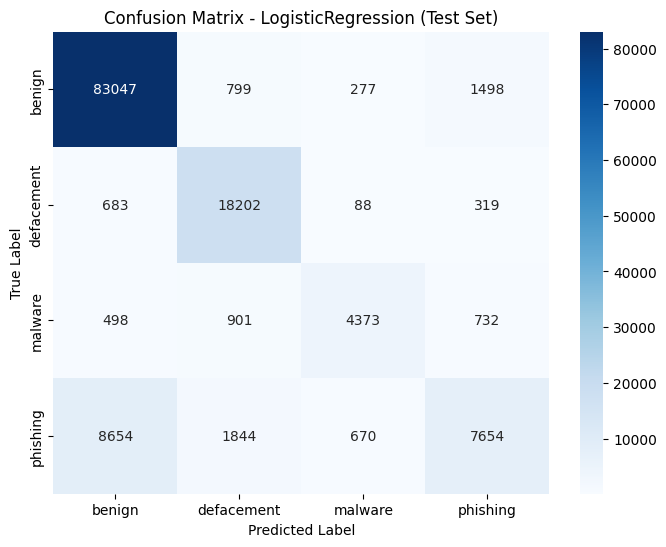


--- Evaluating RandomForest ---

Training Metrics for RandomForest:
Accuracy: 0.9733142400835394
Precision: 0.9729850848758835
Recall: 0.9733142400835394
F1-score: 0.9729514354795006

Testing Metrics for RandomForest:
Accuracy: 0.9596127120140664
Precision: 0.9588424279951241
Recall: 0.9596127120140664
F1-score: 0.9589228278744272
ROC AUC: Not directly applicable for multiclass with current setup

Confusion Matrix for RandomForest (Test Set):


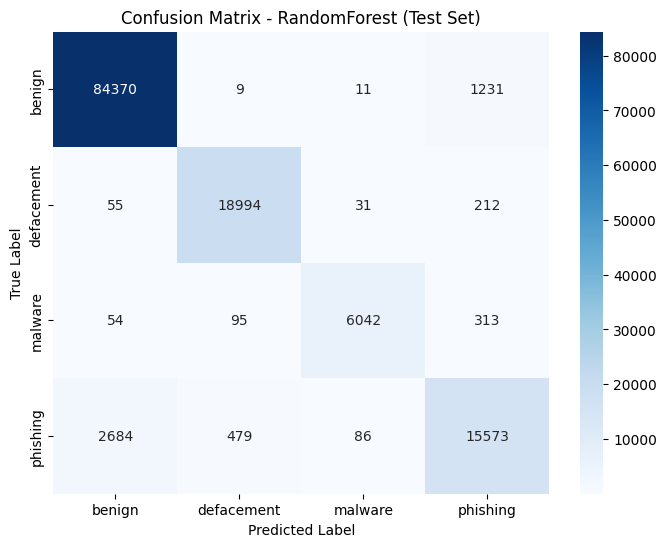

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

for name, res in results.items():
    print(f"\n--- Evaluating {name} ---")

    y_pred_train = res['y_pred_train']
    y_pred_test = res['y_pred_test']
    y_proba_test = res['y_proba_test']

    # Calculate and print metrics for training set
    print(f"\nTraining Metrics for {name}:")
    print('Accuracy:', accuracy_score(y_train, y_pred_train))
    print('Precision:', precision_score(y_train, y_pred_train, average='weighted', zero_division=0))
    print('Recall:', recall_score(y_train, y_pred_train, average='weighted', zero_division=0))
    print('F1-score:', f1_score(y_train, y_pred_train, average='weighted', zero_division=0))

    # Calculate and print metrics for testing set
    print(f"\nTesting Metrics for {name}:")
    print('Accuracy:', accuracy_score(y_test, y_pred_test))
    print('Precision:', precision_score(y_test, y_pred_test, average='weighted', zero_division=0))
    print('Recall:', recall_score(y_test, y_pred_test, average='weighted', zero_division=0))
    print('F1-score:', f1_score(y_test, y_pred_test, average='weighted', zero_division=0))

    # Calculate and print ROC AUC if probabilities are available
    if y_proba_test is not None and len(np.unique(y_test)) == 2: # ROC AUC for binary classification
        print('ROC AUC:', roc_auc_score(y_test, y_proba_test))
    elif y_proba_test is not None and len(np.unique(y_test)) > 2:
        # For multiclass, roc_auc_score requires one-hot encoded y_true
        # This part requires more advanced handling for multiclass ROC AUC if needed
        # For now, we'll skip if not binary
        print('ROC AUC: Not directly applicable for multiclass with current setup')

    # Generate and display confusion matrix for the testing set
    print(f"\nConfusion Matrix for {name} (Test Set):")
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix - {name} (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [43]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Convert y_test to one-hot encoded format
label_binarizer = LabelBinarizer()
y_test_onehot = label_binarizer.fit_transform(y_test)
classes = label_binarizer.classes_

print(f"Original classes: {classes}")
print(f"Shape of one-hot encoded y_test: {y_test_onehot.shape}")

Original classes: ['benign' 'defacement' 'malware' 'phishing']
Shape of one-hot encoded y_test: (130239, 4)



--- Plotting Multiclass ROC Curves for LogisticRegression ---


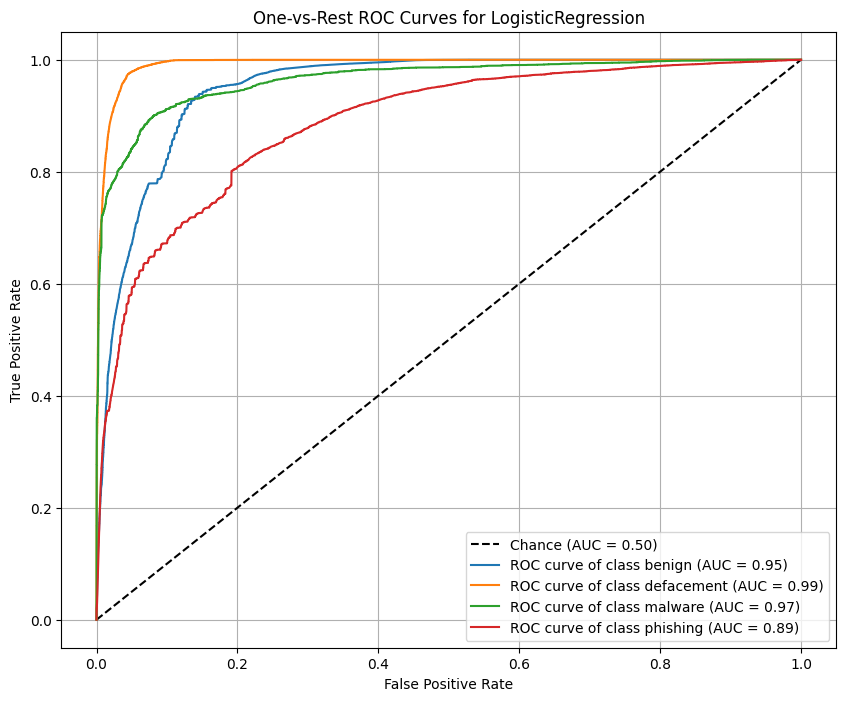


--- Plotting Multiclass ROC Curves for RandomForest ---


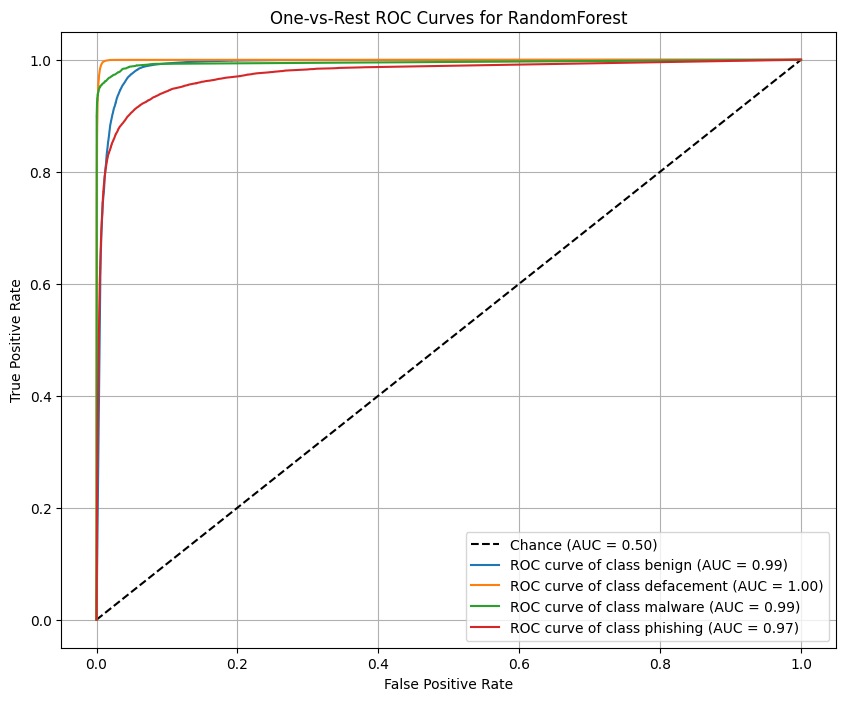

In [44]:
for name, model in models.items():
    print(f"\n--- Plotting Multiclass ROC Curves for {name} ---")

    # Get predicted probabilities for all classes
    y_proba = model.predict_proba(X_test)

    # Plot setup
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')

    # Iterate through each class to plot OvR ROC curve
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve of class {classes[i]} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'One-vs-Rest ROC Curves for {name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [46]:
import joblib

# Define file paths for saving the models
logistic_regression_model_path = 'logistic_regression_model.joblib'
random_forest_model_path = 'random_forest_model.joblib'

# Save the Logistic Regression model
joblib.dump(clf_lr, logistic_regression_model_path)
print(f"Logistic Regression model saved to {logistic_regression_model_path}")

# Save the Random Forest model
joblib.dump(clf_rf, random_forest_model_path)
print(f"Random Forest model saved to {random_forest_model_path}")

Logistic Regression model saved to logistic_regression_model.joblib
Random Forest model saved to random_forest_model.joblib
